# Semantic Segmentation on Cilia Images using Tiramisu Network in PyTorch


This is a PyTorch implementation of "The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation" (https://arxiv.org/pdf/1611.09326.pdf). This repository is created over the course of two weeks for the project 4 of CSCI 8360 Data Science Practicum at University of Georgia in Spring 2018. 

This repository is benefited from Bendan Fortuner(@bfortuner)'s implementation (https://github.com/bfortuner/pytorch_tiramisu) and ZijunDeng(@ZijunDeng)'s implementation (https://github.com/ZijunDeng/pytorch-semantic-segmentation). 

The goal of this project is to find cilia from a time series of images. Here is a glance of what the data is like:
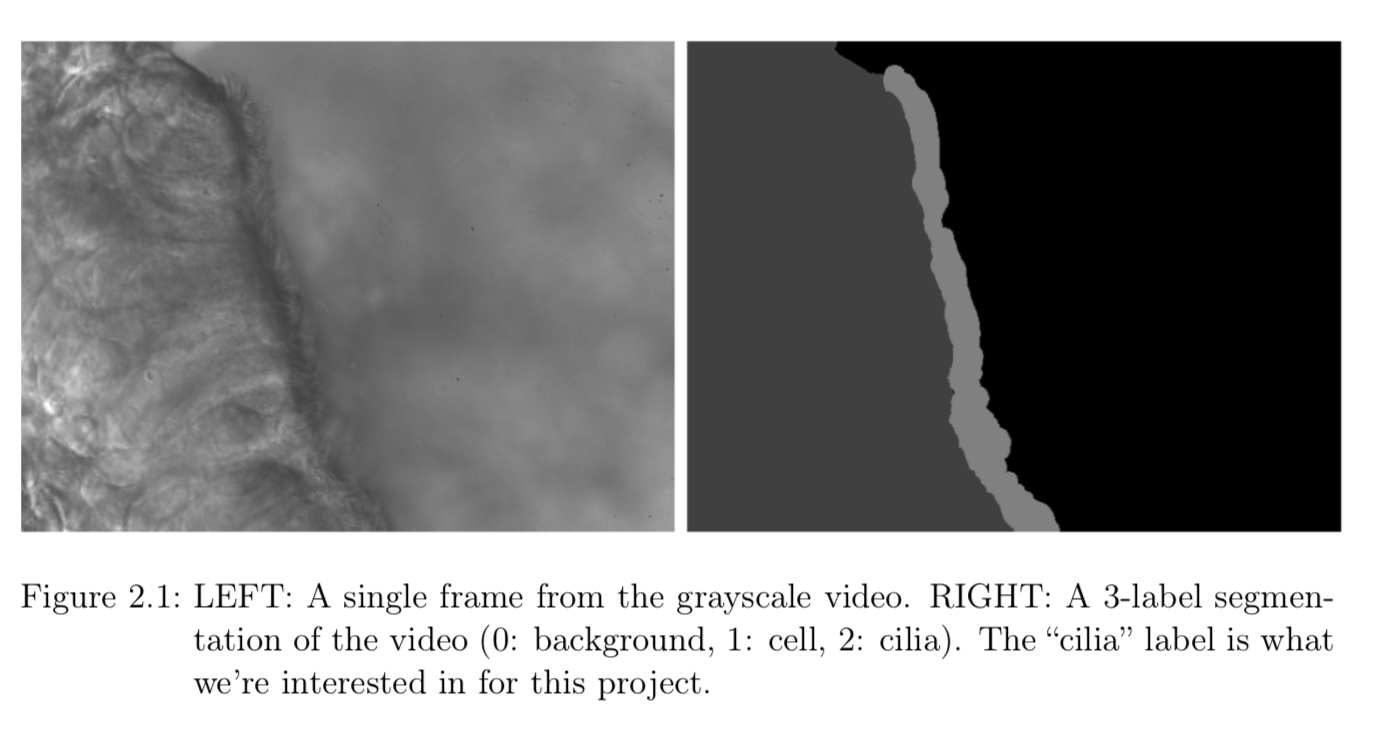 

Cilia motion is an active area of research. Here we are having a small slice of it. There are 100 accompany frames in each cilia motion video. In evaluation, the goal is to only find the cilia (with label 2). The evaluation metric is the area region of intersection-over-union (IoU).

For more background information, check Quinn, Shannon P., et al. "Automated identification of abnormal respiratory ciliary motion in nasal biopsies." Science translational medicine 7.299 (2015): 299ra124-299ra124. (http://stm.sciencemag.org/content/7/299/299ra124).

The reason to use Tiramisu Network (FC-DenseNet) is that there is ample evidence for its effectiveness, and it combines the advanatges of DenseNet and UNet. 

## Loading the required libraries

In [1]:
from datasets import cilia, joint_transforms
from utils import training_utils
from models import tiramisu

import torch
from torchvision import transforms
from torch.utils import data
from imageio import imwrite, imread

from pathlib import Path
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import time

## Check PyTorch GPU support

As I will show it later, the code theoretically could also run on a CPU, and we provide APIs for generating masks for the testing set by using the trained model on a CPU. But GPU is much much much better in training. Strongly suggested.

In [2]:
try:
    print ('Your GPU is {}'.format(torch.cuda.get_device_name(0)))
except AttributeError:
    print ('No GPU found!')

Your GPU is Quadro P6000


## Load the Training Data

In these following steps, we load the training data. There are in total 211 videos (each with 100 frames) of cilia data. We only take the first frame of it (because although cilia moves in these frames, the range is still not much. We do not take the mean of 100 frames, because the mean would protentially also confuse the network. So we just still to the first one.) 

So we have 211 images and 211 corresponding masks (ground truths). Next, we separate these 211 images and their corresponding masks into training and validiation sets. We have different sizes of the training set in our experiment but in the end the ratio between training and validation datasets is around 9:1. 

In order to load the data into PyTorch, they have to be able to be called from PyTorch's `Dataloader`. Moreover, to augment our dataset, we use RandomSizedCrop and RandomHorizontallyFlip and the training set. (Following the method in C. Lu, M. Marx, C. Chennubhotla, M. Zahid, C. W. Lo, and S. Quinn. "Stacked Neural Networks for Automated Ciliary Motion Analysis." IEEE ISBI. https://arxiv.org/abs/1803.07534) Another benefit of RandomSizedCrop is that it compensates the different demensions of training images, which are (256, 256), (480, 640), etc. due to different techniques in recording. We also provide the option of removing and not removing the cell segments for training (again, it's because the evaluation is only about the cilia.) In this demo, we choose not to remove the cell regions (which is the default setting; to remove them, just change `remove_cell` to `True`.)

In [3]:
# Specify the path for folder
ROOT = '/home/afarahani/Projects/project2/dataset/data/data/'

train_joint_transformer = transforms.Compose([
    joint_transforms.ResizeImage(256), 
    joint_transforms.JointRandomHorizontalFlip()
    ])

train_cilia = cilia.Cilia(ROOT,
    joint_transform = train_joint_transformer
    )

## Load the training data into PyTorch

In [4]:
train_loader = data.DataLoader(train_cilia, batch_size = 1, shuffle = True)

### Check the input and target images

Here we take a brief look at the images we have loaded. Notice that the input images are in grey-scale (i.e. only 1 channel).

In [5]:
input_a, target_a = next(iter(train_loader))
print (input_a.size(), target_a.size())

torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])


/home/afarahani/.local/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Plot on what the image and ground-truth mask are like 


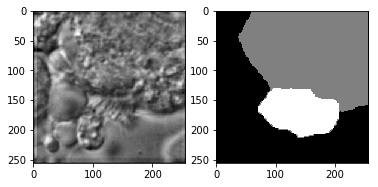

In [6]:
figure, subplot = plt.subplots(1,2)
subplot[0].imshow(input_a[0, 0, :, :], cmap = 'gray')
subplot[1].imshow(target_a[0, :, :], cmap = 'gray')

It Seems that PyTorch dataloader automatically changes the range to (0,1) after calling ToTensor(). So it saves our effort of normalization by dividing the image by 255.

In [7]:
input_a[0, 0, :, :], target_a[0, :, :]

(tensor([[0.4118, 0.5216, 0.4667,  ..., 0.3804, 0.4000, 0.3098],
         [0.4824, 0.6157, 0.5529,  ..., 0.4941, 0.5255, 0.4039],
         [0.3569, 0.4549, 0.4118,  ..., 0.4706, 0.5059, 0.3922],
         ...,
         [0.2392, 0.3216, 0.3255,  ..., 0.3333, 0.3490, 0.2667],
         [0.2549, 0.3451, 0.3529,  ..., 0.3294, 0.3412, 0.2588],
         [0.1961, 0.2667, 0.2745,  ..., 0.2471, 0.2510, 0.1882]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 1, 0],
         [0, 0, 0,  ..., 1, 1, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]))

## Training

Now let's come to the training part. There are the hypoparameters we use.  

In [ ]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 1000
torch.cuda.manual_seed(0) # use manual seed for reproductivity

In the `models/tiramisu.py`, there are three different models of Tiramisu implemented -- FCDenseNet57, FCDenseNet67, and FCDenseNet103. For optimal performance, it didn't take us too long to settle on FCDenseNet103. 

For the loss function, we use `NLLLoss` in PyTorch, which is cross-entropy loss, which is the negative log likelihood loss. Alternatively, maybe we can use `CrossEntropyLoss` (need to further test it).

Adam is a good optimizer to use (in our experiments, it works better than SGD, RMSProp, Adagrad).

In [ ]:
class DiceLoss:
    """
    Loss defined as BCE - log(soft_jaccard)
    Vladimir Iglovikov, Sergey Mushinskiy, Vladimir Osin,
    Satellite Imagery Feature Detection using Deep Convolutional Neural Network: A Kaggle Competition
    arXiv:1706.06169
    """
    def __call__(self, output, target, weights=None, ignore_index=None):
        """
        output : NxCxHxW Variable
        target :  NxHxW LongTensor
        weights : C FloatTensor
        ignore_index : int index to ignore from loss
        """
        eps = 0.0001

        output = output.exp()
        encoded_target = output.detach() * 0
        if ignore_index is not None:
            mask = target == ignore_index
            target = target.clone()
            target[mask] = 0
            encoded_target.scatter_(1, target.unsqueeze(1), 1)
            mask = mask.unsqueeze(1).expand_as(encoded_target)
            encoded_target[mask] = 0
        else:
            encoded_target.scatter_(1, target.unsqueeze(1), 1)

        if weights is None:
            weights = torch.tensor([0.9, 0.1]).cuda()

        intersection = output * encoded_target
        numerator = 2 * intersection.sum(0).sum(1).sum(1)
        denominator = output + encoded_target

        if ignore_index is not None:
            denominator[mask] = 0
        denominator = denominator.sum(0).sum(1).sum(1) + eps
        loss_per_channel = weights * (1 - (numerator / denominator))

        return loss_per_channel.sum() / output.size(1)

In [ ]:
class DiceLoss:
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    def __call__(self, logits, true, eps=1e-7):
        """Computes the Jaccard loss, a.k.a the IoU loss.
        Note that PyTorch optimizers minimize a loss. In this
        case, we would like to maximize the jaccard loss so we
        return the negated jaccard loss.
        Args:
            true: a tensor of shape [B, H, W] or [B, 1, H, W].
            logits: a tensor of shape [B, C, H, W]. Corresponds to
                the raw output or logits of the model.
            eps: added to the denominator for numerical stability.
        Returns:
            jacc_loss: the Jaccard loss.
        """
        num_classes = logits.shape[1]
        if num_classes == 1:
            true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
            true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
            true_1_hot_f = true_1_hot[:, 0:1, :, :]
            true_1_hot_s = true_1_hot[:, 1:2, :, :]
            true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
            pos_prob = torch.sigmoid(logits)
            neg_prob = 1 - pos_prob
            probas = torch.cat([pos_prob, neg_prob], dim=1)
        else:
            true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
            true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
            probas = logits # torch.softmax(logits, dim=1)
        true_1_hot = true_1_hot.type(logits.type())
        dims = (0,) + tuple(range(2, true.ndimension()))
        intersection = torch.sum(probas * true_1_hot, dims)
        cardinality = torch.sum(probas + true_1_hot, dims)
        union = cardinality - intersection
        jacc_loss = (intersection / (union + eps)).mean()
        return (1 - jacc_loss)

In [ ]:
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1).cuda()
model.apply(training_utils.weights_init)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
# criterion = FocalLoss()
# criterion = nn.NLLLoss(weight=torch.tensor([0.7, 0.2, 0.1]).cuda()).cuda()
criterion = torch.nn.NLLLoss().cuda()

Now we load the valiation set. It uses the same data loader, but we added `validate`. (Default is `train`).

We put the batch_size to 1 here. In validation set, the input images have different sizes, so it's better to do it one by one.

In [ ]:
val_cilia = cilia.Cilia(ROOT, 'validate')

val_loader = torch.utils.data.DataLoader(
                val_cilia, batch_size=1, shuffle=True)

Check (and build) the saved path for storing the results.

In [ ]:
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)

Now we start training. Notice we save our model *every step*, because the performance may vary a lot (depending on how you set your parameters). We shall choose the one with low validation loss (high validation accuracy). The training result is from a GPU.

In [ ]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = training_utils.train(
        model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1 - trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    val_loss, val_err = training_utils.test(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1 - val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    training_utils.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    training_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

## Getting Results

In this part of the notebook, we show how to get results from a saved model.

### Loading a model from a GPU

Notice that we have `cuda()` added.

In [34]:
model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1).cuda()
model.load_state_dict(torch.load('/home/afarahani/Projects/project2/team-linden-p2/src/tiramisu/.weights/weights-387-1.845-0.241.pth')['state_dict'])

### Loading the testing set

Again, since the input images have different sizes, so we need to do it one by one. (i.e. set `batch_size` to 1).

In [35]:
test_cilia = cilia.Cilia(ROOT, 'test')


test_loader = torch.utils.data.DataLoader(
                test_cilia, 
                batch_size=1, 
                shuffle=False
                )
    

### Writing results

In [36]:
test_dir = sorted(os.listdir(ROOT + 'test' + '/data/'))
for i, pic in enumerate(test_loader):
    pred = training_utils.get_test_results(model, pic)
    pred_img = pred[0, :, :]
    pred_img[pred_img == 1] = 0
    imwrite('.results/' + test_dir[i] + '.png', pred_img.numpy().astype(np.uint8))
    

### Now, how to load a model and generate results from a CPU?

We provide similar methods here. In my experience, generating masks for the testing set (114 images) on my MacBook Pro (Early 2015 version, 8G RAM, 2.7G Hz CPU) takes around 75 minutes, and takes a 1080 Ti GPU with 64G RAM machine less than a minute. 

In [ ]:
# To load a model from CPU

model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1)
model.load_state_dict(torch.load('/Users/yuanmingshi/Downloads/weights-974-0.893-0.277.pth',  map_location='cpu')['state_dict'])

# Write test results
test_dir = sorted(os.listdir(ROOT + 'test' + '/data/'))
for i, pic in enumerate(test_loader):
    pred = training_utils.get_test_results_cpu(model, pic, useGPU=False)
    pred_img = pred[0, :, :]
    pred_img[pred_img == 1] = 0
    imwrite('.results/' + test_dir[i] + '.png', pred_img.numpy().astype(np.uint8))
    print (str(i) + 'th image done!')

### Let's see how the results are like!

Here we plot the first image in the testing set and its generated mask (final version).

63028f82447cf6718b90e39068a48ffbe5be0ceae6ae74a80684c5a607778b71
2344


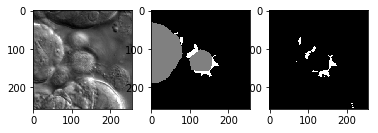

72925ac253a5766016f16f309321f4919c73d349aa27a98e2c4fae8306063cb3
2930


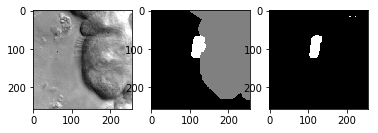

8611595183dd5296dc66586e1c5ef2f13399409585260eb24c53fe6292b070df
1974


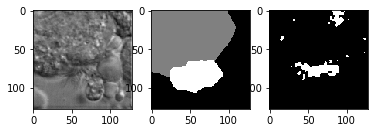

979601fe6004f3ef6939356c64b36e8fbf22162460f41be18a3aa174df0c91da
28410


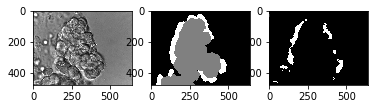

a3e911f7dc84a43f960559272698fa8ae2a0678364abc11ba064be88d7907c1f
34940


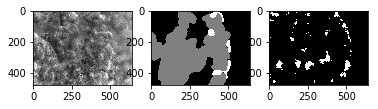

a7e37600a431fa6d6023514df87cfc8bb5ec028fb6346a10c2ececc563cc5423
4750


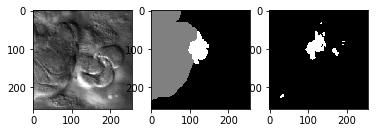

a9e41f8636a83e0751147790b2bd280453ad2ea3656f6c454b221a7e53425dd8
6222


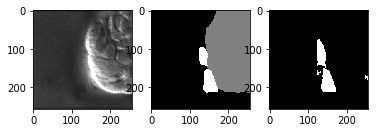

aa241a66147e2123cca6e868e9e099d0d029ea75ab76cf6222625633c421f5c1
37778


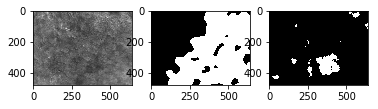

ac25dccd3bcde1ffc71437b2ee62d08fac86d11970d72e230a2ec5b7ad1c8404
55184


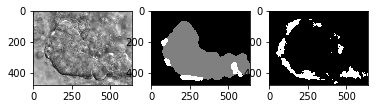

af0797e6b3f7aaaea168f4a7be3b201991a54ba29d590c9764dfcc0475c4a02b
18304


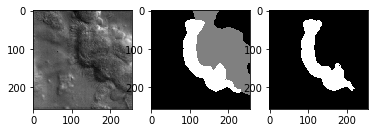

In [27]:
for idx in range(len(test_dir)):
    test_a = imread('/home/afarahani/Projects/project2/dataset/data/data/test/data/' + test_dir[idx] + '/frame0000.png')
    test_mask_a = imread('/home/afarahani/Projects/project2/dataset/data/data/test/masks/' + test_dir[idx] + '.png')
    test_res_a = imread('.results/' + test_dir[idx] + '.png')
    figure, subplot = plt.subplots(1,3)
    print(test_dir[idx])
    print(np.sum(test_res_a))
    subplot[0].imshow(test_a, cmap='gray', aspect = 'equal')
    subplot[1].imshow(test_mask_a, cmap='gray', aspect = 'equal')
    subplot[2].imshow(test_res_a, cmap='gray', aspect = 'equal')
    plt.show()